In [4]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Stitcher():
    def __init__(self, input_dir, output_dir, feature_detector="SIFT", matcher_type="BF", plot=False):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.matcher_type = matcher_type
        self.plot = plot  # Plotting flag
        self.input_images = []
        
        # Feature Detector
        if feature_detector == "SIFT":
            self.feature_detector = cv2.SIFT_create()
        elif feature_detector == "ORB":
            self.feature_detector = cv2.ORB_create()
        else:
            raise ValueError("Invalid feature detector. Use 'SIFT' or 'ORB'.")
        
        self.feature_points_and_descriptors = []
        
        # Initialize matcher
        if self.matcher_type == "BF":
            norm_type = cv2.NORM_L2 if feature_detector == "SIFT" else cv2.NORM_HAMMING
            self.matcher = cv2.BFMatcher(norm_type, crossCheck=False)
        elif self.matcher_type == "FLANN":
            index_params = dict(algorithm=1, trees=5)
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
        else:
            raise ValueError("Invalid matcher type. Use 'BF' or 'FLANN'.")

    def read_input_dir(self):
        image_extensions = {".jpeg", ".jpg", ".png"}
        
        # Filter and sort files by numeric prefix
        files = [f for f in os.listdir(self.input_dir) if os.path.splitext(f)[1].lower() in image_extensions]
        files.sort(key=lambda f: int(re.match(r'(\d+)', f).group()))
        
        for file in files:
            img = cv2.imread(os.path.join(self.input_dir, file))
            if img is not None:
                self.input_images.append(img)
            else:
                print(f"Could not read image {file} in {self.input_dir}")
        
        if len(self.input_images) < 2:
            raise ValueError("Not enough images in the input directory.")
        else:
            print(f"Found {len(self.input_images)} images in the input directory.")
            
    def detect_keypoints_and_descriptors(self):
        for i, img in enumerate(self.input_images):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = self.feature_detector.detectAndCompute(gray, None)
            if keypoints is not None and descriptors is not None:
                self.feature_points_and_descriptors.append((keypoints, descriptors))
                print(f"Detected {len(keypoints)} keypoints in image {i+1}")
                
                if self.plot:
                    self.plot_features(img, keypoints, title=f"Keypoints in Image {i+1}")
            else:
                print(f"Failed to detect keypoints in image {i+1}")
        print("Feature detection completed.")
    
    def match_features(self, descriptors1, descriptors2):
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        print(f"Found {len(good_matches)} good matches after ratio test.")
        return good_matches

    def plot_features(self, img, keypoints, title="Detected Keypoints"):
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()

    def plot_matches(self, img1, img2, kp1, kp2, good_matches):
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title("Feature Matches")
        plt.axis("off")
        plt.show()

    def align_and_stitch_images(self):
        # Initialize the first image as the base for stitching
        result_img = self.input_images[0]
        
        for i in range(len(self.input_images) - 1):
            img1 = result_img
            img2 = self.input_images[i + 1]
            
            kp1, des1 = self.feature_points_and_descriptors[i]
            kp2, des2 = self.feature_points_and_descriptors[i + 1]
            
            # Match features between the current base image and the next image
            good_matches = self.match_features(des1, des2)
            
            if self.plot:
                self.plot_matches(img1, img2, kp1, kp2, good_matches)
            
            # Obtain homography matrix to transform img2 to align with img1
            points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
            
            # Warp img2 to align with img1 and create a larger canvas for stitching
            height, width = img1.shape[:2]
            img2_warped = cv2.warpPerspective(img2, H, (width + img2.shape[1], height))
            
            # Copy img1 onto the warped canvas
            img2_warped[0:height, 0:width] = img1
            result_img = img2_warped
            
            if self.plot:
                self.plot_stitched_image(result_img, title=f"Stitched Panorama after image {i + 2}")

        # Save the final stitched image
        output_path = os.path.join(self.output_dir, "stitched_panorama.jpg")
        cv2.imwrite(output_path, result_img)
        print(f"Stitched panorama saved at {output_path}")



    def plot_stitched_image(self, image, title="Stitched Panorama"):
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()



Found 7 images in the input directory.
Detected 552 keypoints in image 1


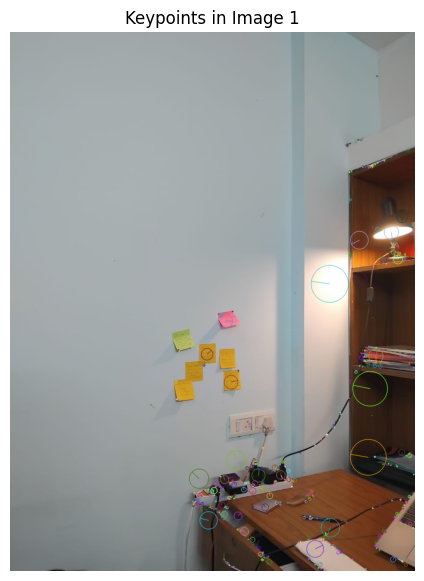

Detected 1267 keypoints in image 2


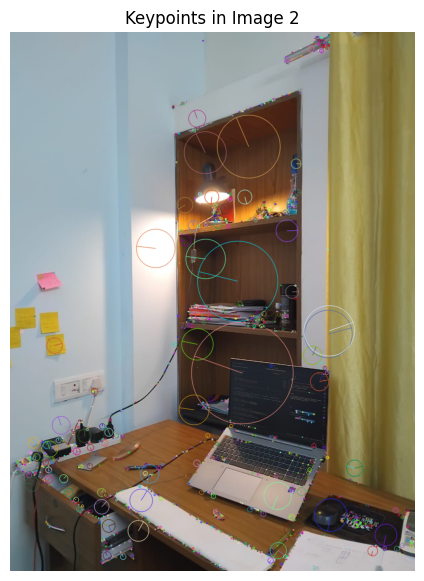

Detected 892 keypoints in image 3


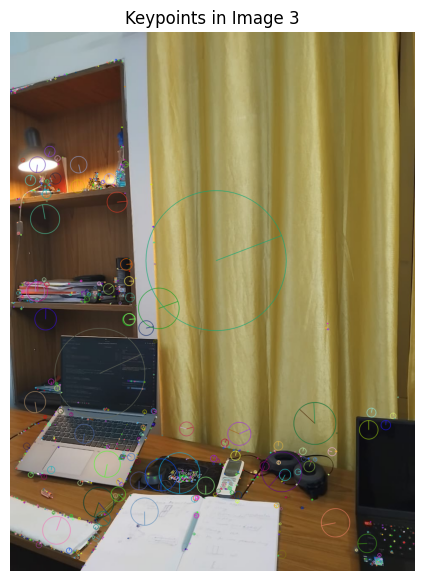

Detected 344 keypoints in image 4


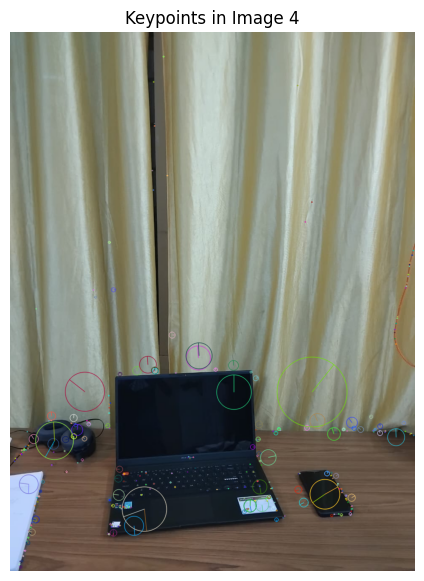

Detected 1173 keypoints in image 5


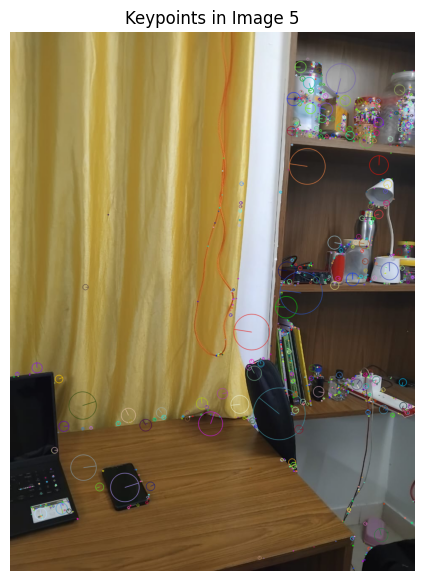

Detected 1411 keypoints in image 6


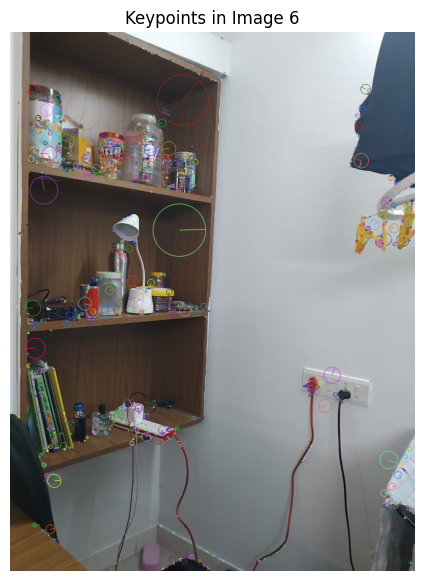

Detected 1275 keypoints in image 7


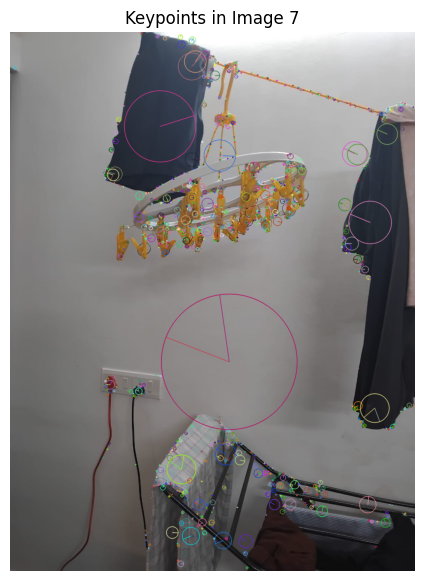

Feature detection completed.


In [9]:

# Example usage:
stitcher = Stitcher(input_dir="data/hostel_room_sequence", output_dir="data/outputs", feature_detector="SIFT", matcher_type="BF", plot=True)
stitcher.read_input_dir()
stitcher.detect_keypoints_and_descriptors()


Found 167 good matches after ratio test.


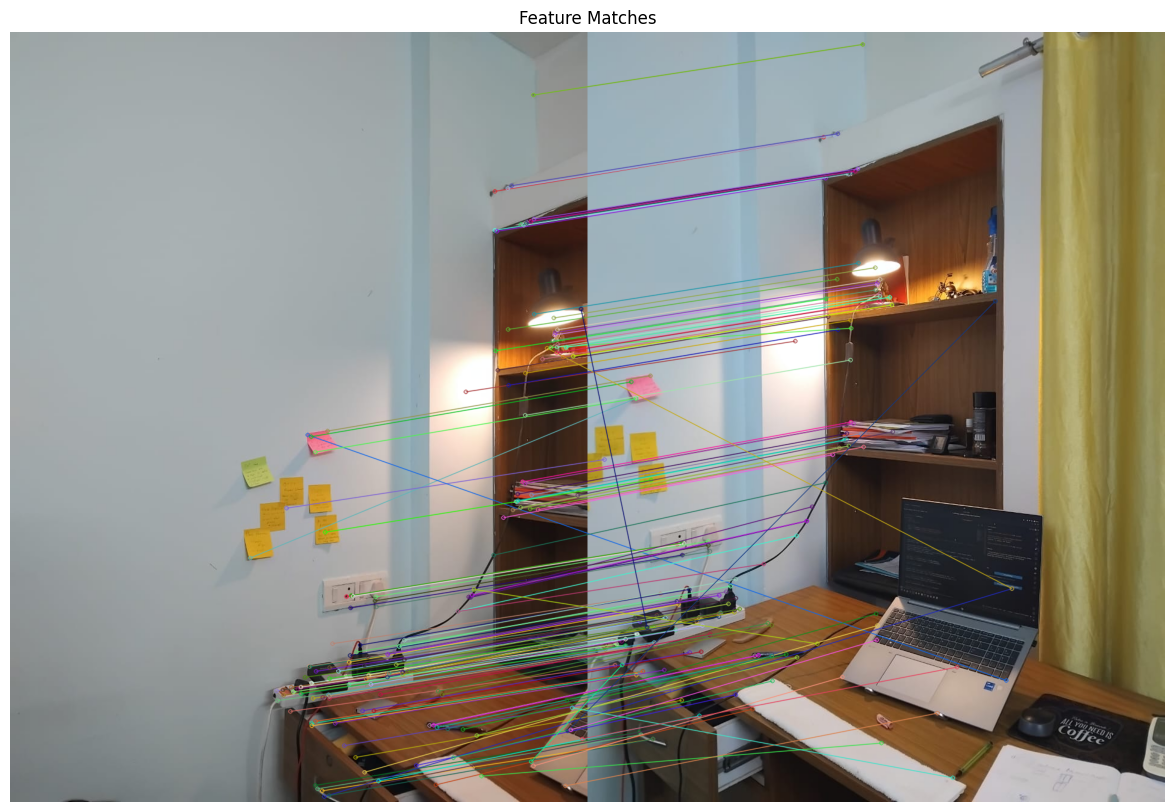

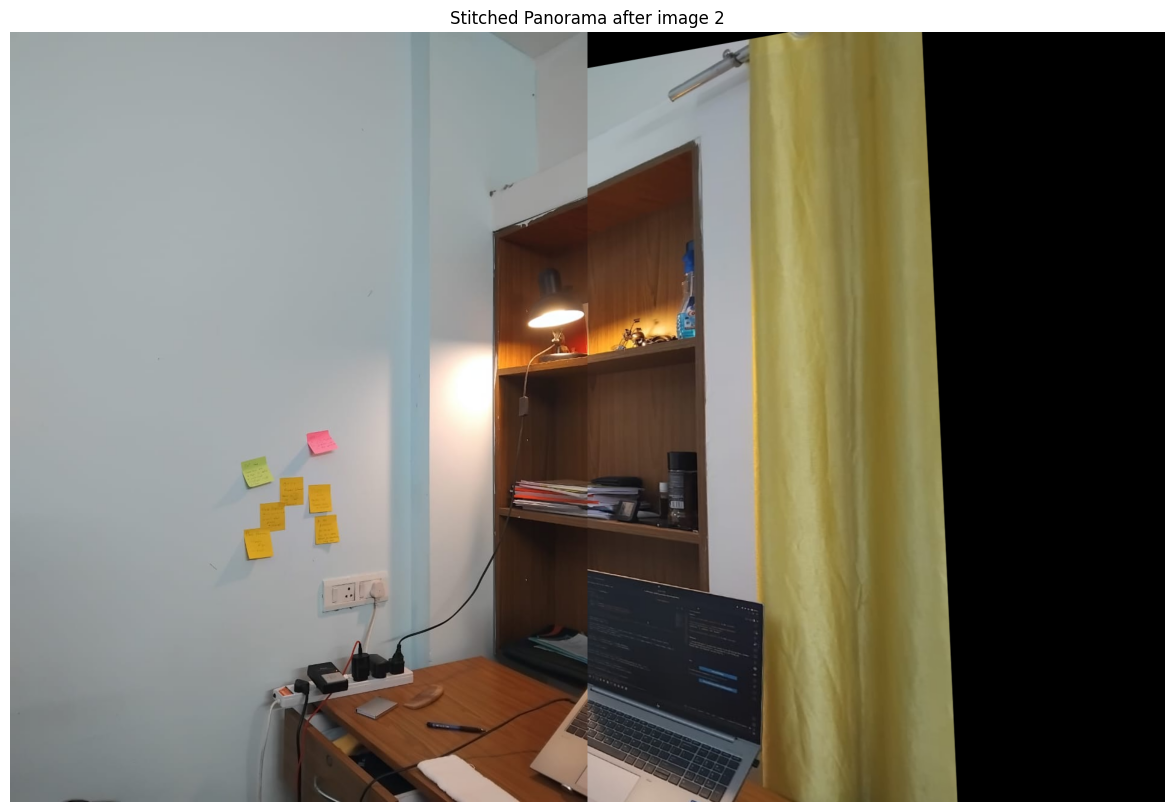

Found 247 good matches after ratio test.


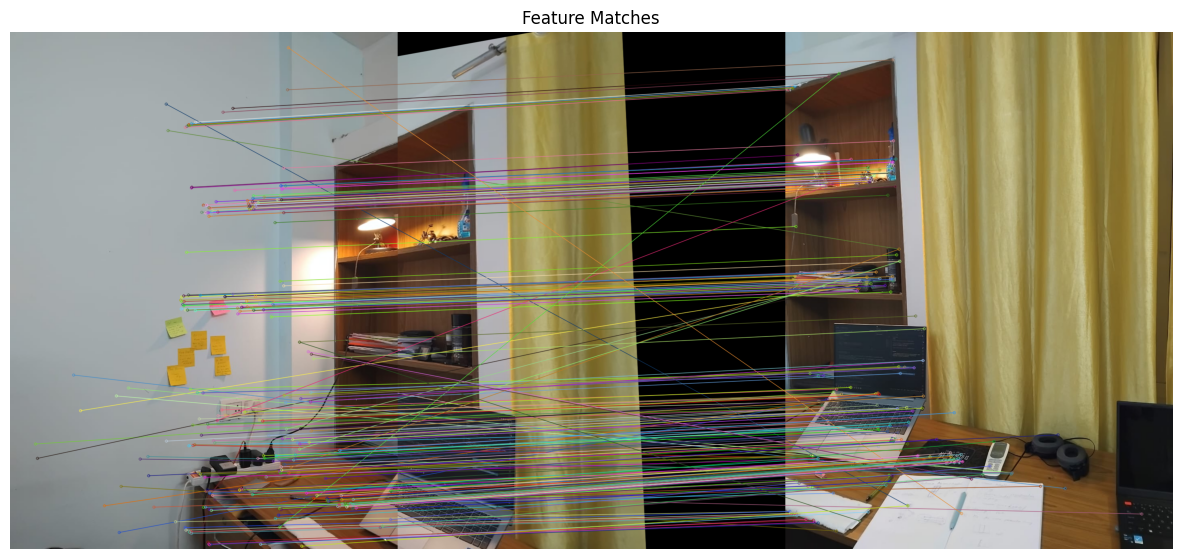

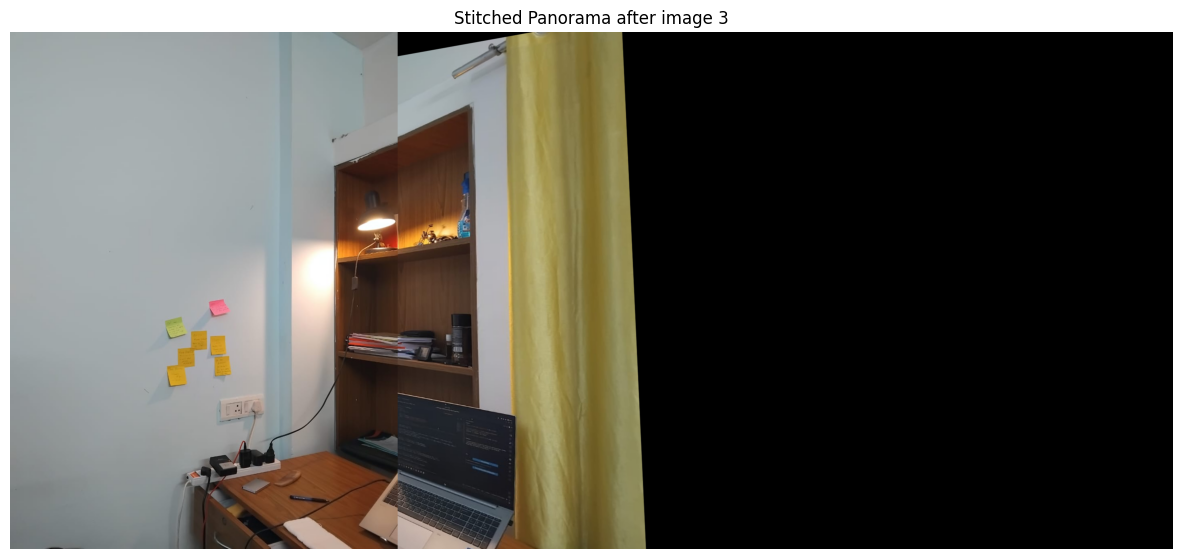

Found 71 good matches after ratio test.


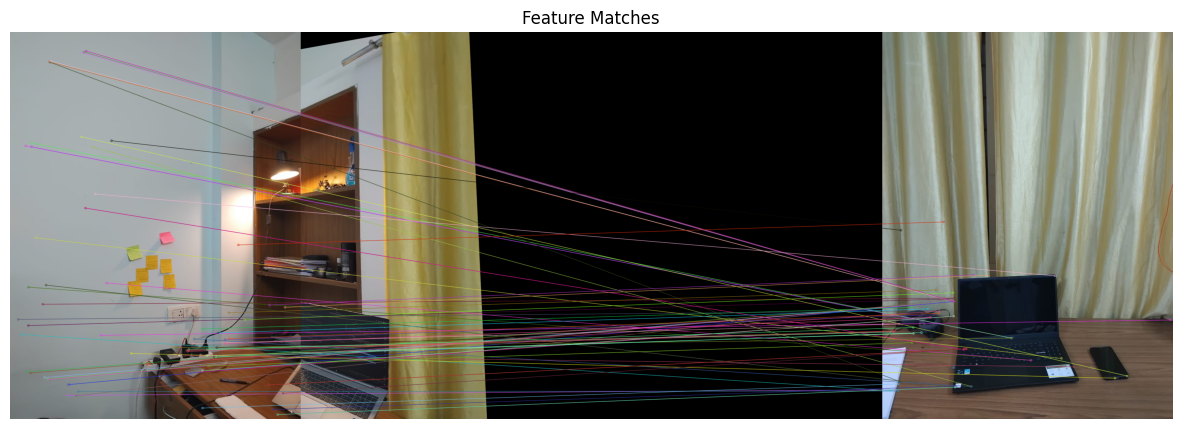

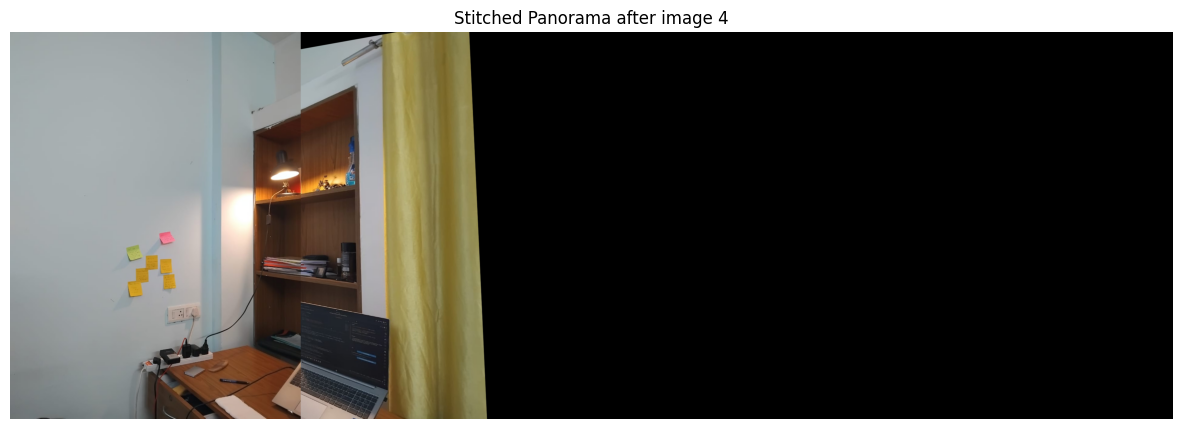

Found 57 good matches after ratio test.


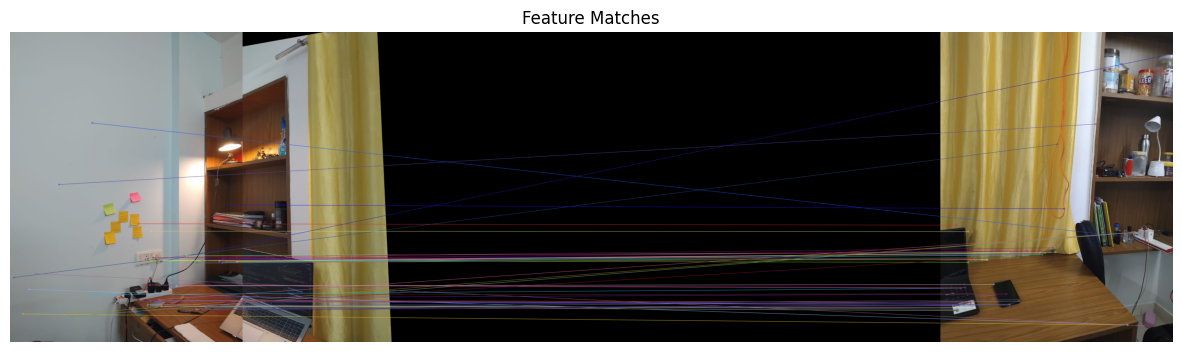

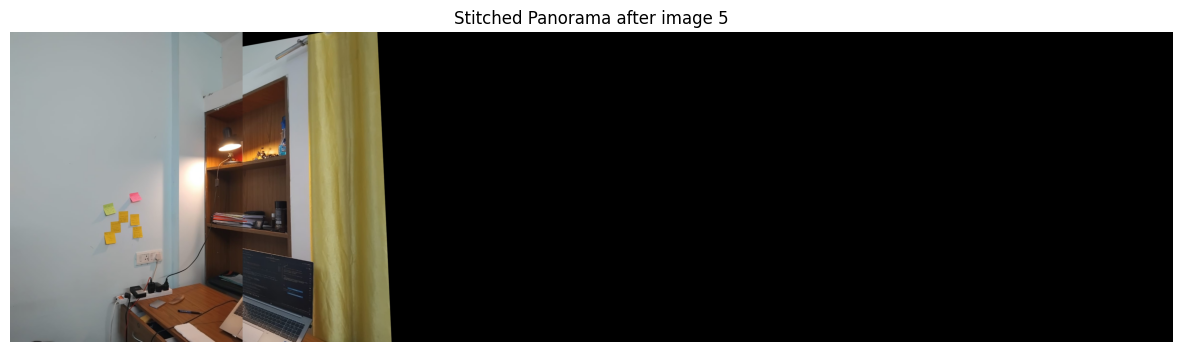

Found 328 good matches after ratio test.


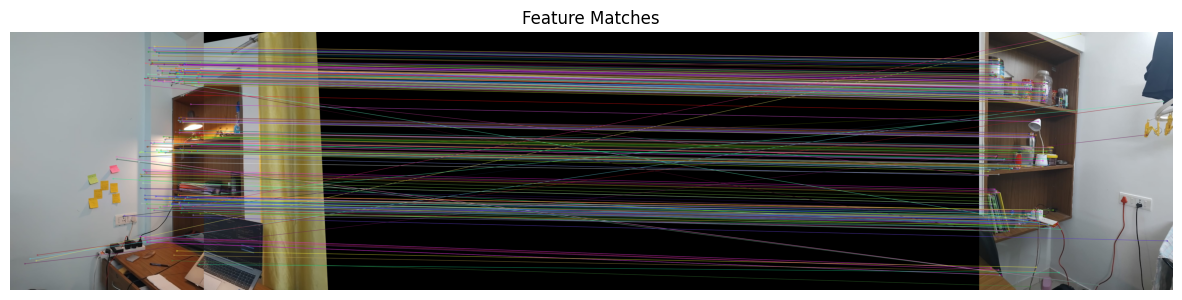

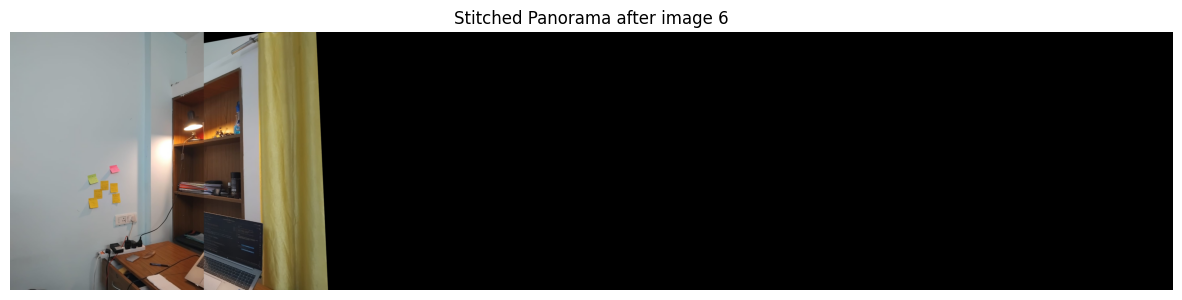

Found 71 good matches after ratio test.


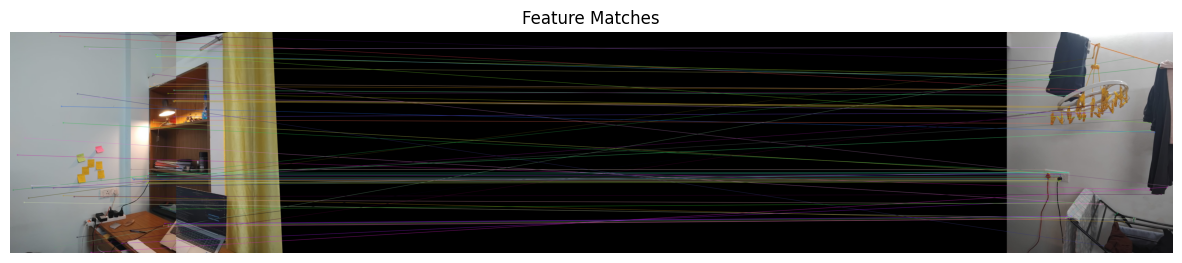

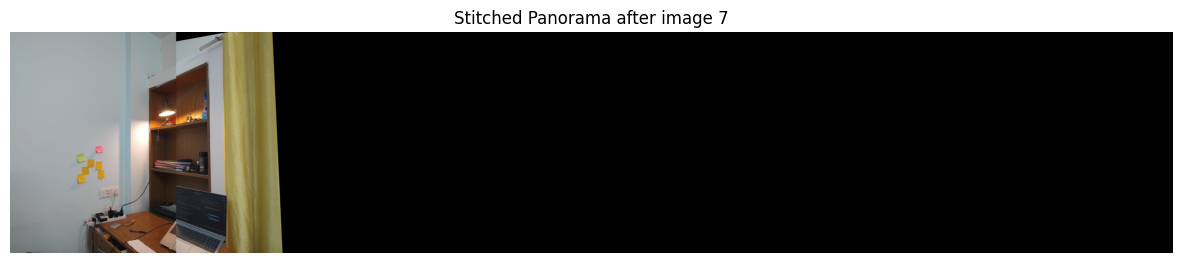

Stitched panorama saved at data/outputs/stitched_panorama.jpg


In [10]:
stitcher.align_and_stitch_images()